<a href="https://colab.research.google.com/github/omer-re/wa_parser/blob/master/wa_parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# source/inspired by: https://www.imrankhan.dev/pages/Exploring%20WhatsApp%20chats%20with%20Python.html
import datetime

from dateutil.parser import parse
import pandas as pd
import re
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from google.colab import files

In [ ]:
def is_date(string, fuzzy=False):
    """
    Return whether the string can be interpreted as a date.

    :param string: str, string to check for date
    :param fuzzy: bool, ignore unknown tokens in string if True
    """
    try:
        parse(string, fuzzy=fuzzy)
        return True

    except ValueError:
        return False

In [ ]:
file = files.upload()
chat_file = f"/content/{list(file.keys())[0]}"

Saving mob-ilai.txt to mob-ilai (3).txt


In [ ]:
def parse_file(text_file):
    senders = []; messages = []; dates=[];times = []; timestamps=[]; directions=[];minutes=[];hours=[];

    word_list=['מעלית','חכו']
    f=open(chat_file,'r',encoding='utf8')
    lines=f.readlines()
    for i,line in enumerate(lines):
        if ('/' in line[:4]) and is_date(line.split('-',1)[0].split(',',1)[0]):
            date=line.split('-',1)[0].split(',',1)[0]
            try:
                time=line.split('-',1)[0].split(',',1)[1]
            except:
                print(line)
            sender_message=line.split('-',1)[1]
            separator=sender_message.find(':')
            if separator==(-1):
                continue
            timestamp= line.split('-',1)[0]
            sender=sender_message[:separator]
            message=sender_message[separator+1:]

            dates.append(date.strip())
            times.append(time.strip())
            #hr_mn=time.strip().split(':')
            mnt=time.strip().split(':')[1]
            minutes.append(int(mnt[:-3]))
            hour=time.strip().split(':')[0]
            if 'AM' in time or time.strip().startswith('0'):
                direction='morning'
            else:
                direction='evening'
                hour=int(hour)+12
            hours.append(int(hour))
            directions.append(direction)
            senders.append(sender)
            messages.append(message.replace('\n',''))
            timestamps.append(timestamp[:-1])


        else: # it is not a new message but new line of previous message
            new_msg=message+line
            messages[-1]=new_msg


    df = pd.DataFrame(zip(timestamps, dates, times,hours, minutes,directions, senders, messages), columns=['timestamps', 'date', 'time','hours','minutes','direction','sender', 'message'])
    df['timestamps'] = pd.to_datetime(df.timestamps, format='%m/%d/%y, %I:%M %p')
    df['time'] = pd.to_datetime(df.time, format='%I:%M %p').dt.time
    df['date'] = pd.to_datetime(df.date, format='%m/%d/%y').dt.date

    return df

In [ ]:
from prettytable import PrettyTable
import tabulate
# source: https://www.stackvidhya.com/pretty-print-dataframe/
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

df = parse_file(chat_file)


#print(tabulate.tabulate(df, headers='keys', tablefmt='psql'))
df.set_index(df['timestamps'])
df.index=pd.to_datetime(df.index)
#print(df.to_markdown(index=False)) 
print(df.head(20).to_markdown(index=False)) 




| timestamps          | date       | time     |   hours |   minutes | direction   | sender           | message                                                                                                                                                                           |
|:--------------------|:-----------|:---------|--------:|----------:|:------------|:-----------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 2021-02-28 09:14:00 | 2021-02-28 | 09:14:00 |       9 |        14 | morning     | +972 54-338-2794 | בוקר טוב                                                                                                                                                                          |
| 2021-02-28 09:14:00 | 2021-02-28 | 09:14:00 |       9 |        14 | morning     | +972 54-338-2794 | <Media omitted>                                 

In [215]:
laters=df[df['message'].str.contains('לחכות|דקה|חכו|מעלית')]
#print(laters.to_markdown(index=False)) 

contain_words=df[df['message'].str.contains('לחכות|דקה|חכו|מעלית')]
contain_words2=df['message'].str.contains('לחכות|דקה|חכו|מעלית')

after_650=(df['hours']==6)       & (df['minutes']>50)
before_730=df[(df['hours']==7)   & (df['minutes']<30)]
# morning_range_7= (after_650 | before_730)

after_750=(df['hours']==7)       & (df['minutes']>50)
before_830=df[(df['hours']==8)   & (df['minutes']<30)]
# morning_range_8= (after_750 | before_830)

after_1650=df[(df['hours']==16)  & (df['minutes']>50)]
before_1710=df[(df['hours']==17) & (df['minutes']<10)]
# evening_range_17= (after_1650 | before_1710)


after_1750=df[(df['hours']==17)  & (df['minutes']>50)]
before_1810=df[(df['hours']==18) & (df['minutes']<10)]
# evening_range_18= (after_1750 | before_1810)

#result2= df[(contain_words2) & ((morning_range_7) | (morning_range_8) | (evening_range_17) | (evening_range_18))]
# result=df[(df['message'].str.contains('לחכות|דקה|חכו|מעלית')) & 
#           (
#               (after_650 | before_730)
#             | (after_750 | before_830)
#             | (after_1650 | before_1710)
#             | (after_1750 | before_1810)
#           )
#           ]

admins=['+972 50-201-2346', '+972 50-424-0266', '+972 50-571-4490', '+972 50-789-8030', '+972 52-854-5176', '+972 54-338-2794', '+972 54-658-1834']
#admins_mask = df['sender']==(lambda x: any(item for item in selection if item in admins))



laters=df[(df['message'].str.contains('לחכות|דקה|חכו|מעלית'))  &
          (
              ((df['hours']==6) & (df['minutes']>50)  | (df['hours']==7) & (df['minutes']<30))
            | ((df['hours']==7) & (df['minutes']>50)  | (df['hours']==8) & (df['minutes']<30))
            | ((df['hours']==16) & (df['minutes']>50) | (df['hours']==17) & (df['minutes']<10))
            | ((df['hours']==17) & (df['minutes']>50) | (df['hours']==18) & (df['minutes']<10))
          ) 
          ]



#print(laters.to_markdown(index=True))

|                               | timestamps          | date       | time     |   hours |   minutes | direction   | sender              | message                                                                                        |
|:------------------------------|:--------------------|:-----------|:---------|--------:|----------:|:------------|:--------------------|:-----------------------------------------------------------------------------------------------|
| 1970-01-01 00:00:00.000000143 | 2021-03-02 08:09:00 | 2021-03-02 | 08:09:00 |       8 |         9 | morning     | +972 54-476-7300    | חכו בבקשה                                                                                      |
| 1970-01-01 00:00:00.000000167 | 2021-03-03 07:14:00 | 2021-03-03 | 07:14:00 |       7 |        14 | morning     | טל גליקסמן מובילאיי | יכול להיות שאחר בדקה                                                                           |
| 1970-01-01 00:00:00.000000225 | 2021-03-07 17:01:00 | 2021

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f77c0984cd0>,
      dtype=object)

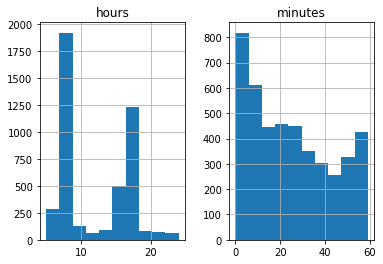

In [211]:
df.hist()

In [263]:
hist=laters.groupby(['sender', 'direction'])['sender'].agg('count').sort_values(ascending=False).head(10)
print(hist)
# todo: each sender should have both his directions, then stack them for each sender

sender             direction
 +972 54-756-0251  evening      14
 +972 52-642-8024  evening      10
 +972 52-550-9152  evening       9
 +972 54-642-6404  evening       8
 +972 58-669-8565  evening       6
 +972 52-786-8032  evening       6
 +972 50-373-7621  evening       6
 +972 54-481-4114  evening       5
 +972 54-424-7424  evening       5
 +972 50-510-0120  evening       5
Name: sender, dtype: int64


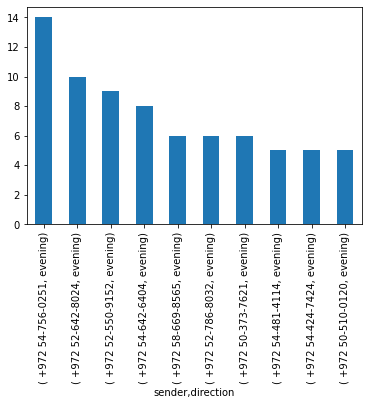

In [253]:
hist.plot.bar(stacked=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(array([[26., 20., 13.,  7., 16.,  5.,  3., 11., 12.,  4.],
        [34., 22., 13.,  7., 16.,  5.,  3., 11., 12.,  4.]]),
 array([ 1. ,  3.9,  6.8,  9.7, 12.6, 15.5, 18.4, 21.3, 24.2, 27.1, 30. ]),
 <a list of 2 Lists of Patches objects>)

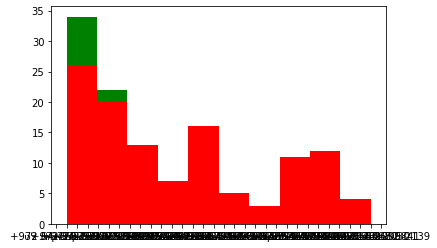

In [243]:
import matplotlib.pyplot as plt

plt.hist([laters['sender'],hist],
          bins=10, range=(1,30), stacked=True, color = ['r','g'])

KeyError: ignored

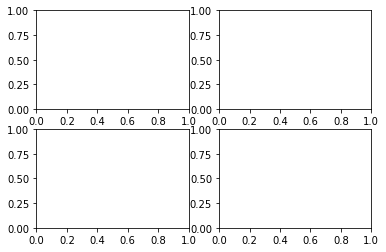

In [246]:
import numpy as np
import matplotlib.pyplot as plt


n_bins = 10
x = laters['sender']

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)

colors = laters['direction']


ax1.hist(x, hist['count'], density=True, histtype='bar', stacked=True)
ax1.set_title('stacked bar')



fig.tight_layout()
plt.show()

In [276]:
import numpy as np
def hist(x):
    h, e = np.histogram(x)
    e = e.astype(int)
    return pd.Series(h, zip(e[:-1], e[1:]))
    
kw = dict(stacked=True, width=1, rot=45)
laters.groupby('direction').sender.apply(hist).unstack(0).plot.bar(**kw)


TypeError: ignored